<a href="https://colab.research.google.com/github/BilalKhaliqWillis/BILAL-Assignment2/blob/main/BILAL_Assignment_8_CLTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Continual Learning and test in Production
#
# This Python script is written in cells.
# The assignment 8: data prep, initial training on Subset A (classes 0-4),
# simulate distribution shift with Subset B (classes 5-9), implement stateless retraining
# and stateful continual training, simulate A/B test, and run an epsilon-greedy bandit
# for model selection. Plots and tables are generated.
#
# Notes:
# - This script uses PyTorch + torchvision.
# - A dataset at /mnt/data/train will be used. Otherwise
# torchvision.datasets.CIFAR10(download=True) will try fetch it.
# - Training settings use small epochs for quick demonstration; increase epochs for
# better results.

# Imports and device
import os
import zipfile
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset, random_split
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

from tqdm import tqdm

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cpu


In [6]:
# Prepare dataset (use local /mnt/data/train.zip)
# This will either unzip and use local files or download CIFAR-10 via torchvision.
from pathlib import Path
import os
import zipfile
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

local_zip = Path('/mnt/data/train.zip')
use_local = local_zip.exists()

data_root = '/mnt/data/cifar10' if use_local else './data'
os.makedirs(data_root, exist_ok=True)

if use_local:
    print('Found local CIFAR-10 archive at', local_zip)
    # unzip archive to data_root
    with zipfile.ZipFile(local_zip, 'r') as z:
        z.extractall(data_root)
else:
    print("No local archive found — will download CIFAR-10 automatically.")

# transforms
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# Use torchvision CIFAR10 dataset
train_dataset = CIFAR10(
    root=data_root,
    train=True,
    download=not use_local,
    transform=transform_train
)

test_dataset = CIFAR10(
    root=data_root,
    train=False,
    download=not use_local,
    transform=transform_test
)

print('Total train samples:', len(train_dataset))
print('Total test samples:', len(test_dataset))


No local archive found — will download CIFAR-10 automatically.


100%|██████████| 170M/170M [00:05<00:00, 32.4MB/s]


Total train samples: 50000
Total test samples: 10000


In [8]:
# Split into Subset A (classes 0-4) and Subset B (classes 5-9)
# Ensuring the balanced classes in each subset by sampling the same number per class

targets = np.array(train_dataset.targets)
class_indices = {i: np.where(targets == i)[0].tolist() for i in range(10)}

# choosing min samples per class to balance within each subset
min_per_class = min(len(class_indices[i]) for i in range(10))
print('Samples per class available:', {i: len(class_indices[i]) for i in range(10)})
print('Using min_per_class =', min_per_class)


# constructing balanced indices for classes 0-4 (A) and 5-9 (B)
indices_A = []
indices_B = []
for c in range(0,5):
    chosen = class_indices[c][:min_per_class]
    indices_A.extend(chosen)
for c in range(5,10):
    chosen = class_indices[c][:min_per_class]
    indices_B.extend(chosen)

# shuffle
random.shuffle(indices_A)
random.shuffle(indices_B)

subsetA = Subset(train_dataset, indices_A)
subsetB = Subset(train_dataset, indices_B)

print('Subset A size:', len(subsetA))
print('Subset B size:', len(subsetB))

# creating validation splits: 80% train / 20% val for each subset
def make_train_val(subset, val_frac=0.2):
    n = len(subset)
    n_val = int(n * val_frac)
    n_train = n - n_val
    train_part, val_part = random_split(subset, [n_train, n_val])
    return train_part, val_part

trainA, valA = make_train_val(subsetA)
trainB, valB = make_train_val(subsetB)

print('trainA:', len(trainA), 'valA:', len(valA))
print('trainB:', len(trainB), 'valB:', len(valB))

# For combined validation set later
val_combined = ConcatDataset([valA, valB])

# Dataloaders helper
BATCH_SIZE = 128

def make_loader(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=2, pin_memory=True)

loader_trainA = make_loader(trainA)
loader_valA = make_loader(valA, shuffle=False)
loader_trainB = make_loader(trainB)
loader_valB = make_loader(valB, shuffle=False)
loader_val_combined = make_loader(val_combined, shuffle=False)

Samples per class available: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Using min_per_class = 5000
Subset A size: 25000
Subset B size: 25000
trainA: 20000 valA: 5000
trainB: 20000 valB: 5000


In [9]:
# Defining a simple CNN for classes 0-4 initially
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4,4)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
# Training & evaluation helpers
def evaluate(model, loader, criterion=None):
    model.eval()
    total = 0
    correct = 0
    losses = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            # remap labels for subsetA (0-4) and subsetB (5-9) contexts handled externally
            out = model(xb)
            preds = out.argmax(dim=1)
            total += yb.size(0)
            correct += (preds == yb).sum().item()
            if criterion is not None:
                losses.append(criterion(out, yb).item())
            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(yb.cpu().tolist())
    acc = correct / total if total>0 else 0
    loss = float(np.mean(losses)) if losses else None
    return acc, loss, all_preds, all_targets

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)


# Helper: remap dataset labels so model sees labels 0..K-1
from torch.utils.data import Dataset
class LabelRemapDataset(Dataset):
    def __init__(self, subset, mapping):
        self.subset = subset
        self.mapping = mapping
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return x, self.mapping[y]

In [11]:
# Train initial model on Subset A (classes 0-4)
# mapping original labels 0-4 -> 0-4 for the model
mappingA = {i: i for i in range(5)}
trainA_mapped = LabelRemapDataset(trainA, mappingA)
valA_mapped = LabelRemapDataset(valA, mappingA)
loader_trainA = make_loader(trainA_mapped)
loader_valA = make_loader(valA_mapped, shuffle=False)

model_init = SimpleCNN(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_init.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

EPOCHS = 5  # changing to 20+ for good results
train_history = {'train_loss': [], 'val_acc': []}
for epoch in range(EPOCHS):
    loss = train_epoch(model_init, loader_trainA, optimizer, criterion)
    acc, _, _, _ = evaluate(model_init, loader_valA, criterion)
    train_history['train_loss'].append(loss)
    train_history['val_acc'].append(acc)
    print(f'Epoch {epoch+1}/{EPOCHS} — train_loss: {loss:.4f} val_acc: {acc:.4f}')

# Evaluating on valA
accA, lossA, _, _ = evaluate(model_init, loader_valA, criterion)
print('Initial model valA acc:', accA)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/5 — train_loss: 1.4536 val_acc: 0.4582
Epoch 2/5 — train_loss: 1.1593 val_acc: 0.5540
Epoch 3/5 — train_loss: 1.0534 val_acc: 0.5810
Epoch 4/5 — train_loss: 0.9988 val_acc: 0.5994
Epoch 5/5 — train_loss: 0.9541 val_acc: 0.6374
Initial model valA acc: 0.641


In [12]:
# Evaluating initial model on Subset B i.e shifted distribution — mapping labels 5-9 -> 0-4 for evaluation
mappingB_to0 = {i: i-5 for i in range(5,10)}
valB_mapped = LabelRemapDataset(valB, mappingB_to0)
loader_valB_mapped = make_loader(valB_mapped, shuffle=False)

# classes 0-4; map B labels to 0-4 and evaluate
acc_on_B, lossB, _, _ = evaluate(model_init, loader_valB_mapped, criterion)
print('Initial model evaluated on Subset B (mapped labels) acc:', acc_on_B)

# Large drop in accuracy indicates the model has not learned features for classes 5-9


Initial model evaluated on Subset B (mapped labels) acc: 0.0608


In [ ]:
# Stateless retraining (train from scratch on A+B combined)
# Combining datasets and create a new model with 10 outputs of classes 0-9
trainAB = ConcatDataset([trainA, trainB])
# mapping for labels: A as 0-4, B as 5-9
# we use a LabelRemap that maps them to 0-9 directly
mappingAB = {i: i for i in range(10)}
trainAB_mapped = LabelRemapDataset(trainAB, mappingAB)

# splitting into train/val for combined training or reuse val_combined
loader_trainAB = make_loader(trainAB_mapped)
loader_valAB = make_loader(val_combined, shuffle=False)

model_stateless = SimpleCNN(num_classes=10).to(device)
# adjust classifier last layer dimensions inside model; SimpleCNN defined for 5 outputs — recreate for 10 outputs
# For simplicity, we'll rebuild a model class that accepts variable num_classes properly
model_stateless = SimpleCNN(num_classes=10).to(device)
optimizer_s = optim.SGD(model_stateless.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion10 = nn.CrossEntropyLoss()

EPOCHS_S = 8
for epoch in range(EPOCHS_S):
    loss = train_epoch(model_stateless, loader_trainAB, optimizer_s, criterion10)
    acc, _, _, _ = evaluate(model_stateless, loader_valAB, criterion10)
    print(f'Stateless Epoch {epoch+1}/{EPOCHS_S} — loss: {loss:.4f} val_acc: {acc:.4f}')

# Evaluating stateless model on valA and valB separately
# For valA and valB, original labels are in 0-9, so we can evaluate directly using valA and valB wrapped in mappingAB
valA_for10 = LabelRemapDataset(valA, mappingAB)
valB_for10 = LabelRemapDataset(valB, mappingAB)
acc_stat_A, _, _, _ = evaluate(model_stateless, make_loader(valA_for10, shuffle=False), criterion10)
acc_stat_B, _, _, _ = evaluate(model_stateless, make_loader(valB_for10, shuffle=False), criterion10)
print('Stateless retrained model — valA acc:', acc_stat_A, 'valB acc:', acc_stat_B)

In [ ]:
# Stateful training with continued training initial model on Subset B
# Need to adapt model_init which has 5 outputs to output 10 classes. Two options:
# (1) Replace final layer to 10 outputs and continue training weights for first 5 classes preserved,
# (2) Add a new head. Option (1) and initialize new weights for additional outputs.

# Creating a new model that shares pretrained feature extractor from model_init
stateful_model = SimpleCNN(num_classes=10).to(device)
# copy feature layers and first linear weight rows for stability
stateful_model.features.load_state_dict(model_init.features.state_dict())
# For classifier copy as much as possible
stateful_clf = stateful_model.classifier
init_clf = model_init.classifier
# Copy weights for matching dimensions where possible
# init_clf last layer maps to 5; we'll copy its first 5 rows into the new last layer
with torch.no_grad():
    # copy first linear (fc) weights and biases
    stateful_model.classifier[1].weight[:init_clf[1].weight.shape[0], :] = init_clf[1].weight.clone()
    stateful_model.classifier[1].bias[:init_clf[1].bias.shape[0]] = init_clf[1].bias.clone()
    # copy second linear (the final) first 5 output weights
    # stateful_model.classifier[4] is final linear (index may vary based on definition) but our Sequential index is [0 Flatten,1 Linear,2 ReLU,3 Dropout,4 Linear]
    stateful_model.classifier[4].weight[:5, :] = init_clf[4].weight.clone()
    stateful_model.classifier[4].bias[:5] = init_clf[4].bias.clone()

# Continue training on trainB but now labels must be remapped to 0-9 (original labels in trainB are 5-9)
trainB_for10 = LabelRemapDataset(trainB, mappingAB)
loader_trainB_for10 = make_loader(trainB_for10)

optimizer_stateful = optim.SGD(stateful_model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
EPOCHS_STATEFUL = 6
for epoch in range(EPOCHS_STATEFUL):
    loss = train_epoch(stateful_model, loader_trainB_for10, optimizer_stateful, criterion10)
    accA_stateful, _, _, _ = evaluate(stateful_model, make_loader(valA_for10, shuffle=False), criterion10)
    accB_stateful, _, _, _ = evaluate(stateful_model, make_loader(valB_for10, shuffle=False), criterion10)
    print(f'Stateful Epoch {epoch+1}/{EPOCHS_STATEFUL} — loss: {loss:.4f} valA_acc: {accA_stateful:.4f} valB_acc: {accB_stateful:.4f}')

# Final stateful eval
acc_state_A, _, _, _ = evaluate(stateful_model, make_loader(valA_for10, shuffle=False), criterion10)
acc_state_B, _, _, _ = evaluate(stateful_model, make_loader(valB_for10, shuffle=False), criterion10)
print('Stateful model — valA acc:', acc_state_A, 'valB acc:', acc_state_B)

In [ ]:
# Comparing stateless vs stateful
print('Comparison:')
print('Stateless — valA:', acc_stat_A, 'valB:', acc_stat_B)
print('Stateful  — valA:', acc_state_A, 'valB:', acc_state_B)

# Simple table text
print('\nPerformance summary:')
print('Model\t\tvalA_acc\tvalB_acc')
print(f'Stateless\t{acc_stat_A:.4f}\t{acc_stat_B:.4f}')
print(f'Stateful \t{acc_state_A:.4f}\t{acc_state_B:.4f}')

In [16]:
#  A/B testing simulation
# using the test set 10k images. Splitting test set into two groups randomly; Group A uses stateless model, Group B uses stateful model.

# Preparing test dataset for evaluation in 0-9 labels i.e already 0-9 in test_dataset.targets
loader_test = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Creating indices for two groups
n_test = len(test_dataset)
indices = list(range(n_test))
random.shuffle(indices)
split = n_test // 2
indices_groupA = indices[:split]
indices_groupB = indices[split:]

def evaluate_on_indices(model, dataset, indices):
    sub = Subset(dataset, indices)
    loader = DataLoader(sub, batch_size=128, shuffle=False)
    acc, _, _, _ = evaluate(model, loader, criterion10)
    return acc

acc_groupA = evaluate_on_indices(model_stateless, test_dataset, indices_groupA)
acc_groupB = evaluate_on_indices(stateful_model, test_dataset, indices_groupB)
print('A/B test — stateless (A) acc:', acc_groupA, 'stateful (B) acc:', acc_groupB)

A/B test — stateless (A) acc: 0.3976 stateful (B) acc: 0.3452


Bandit counts: [9526, 474]
Bandit estimated values (mean reward): [0.4022674784799499, 0.33544303797468367]
Overall bandit average reward: 0.3991


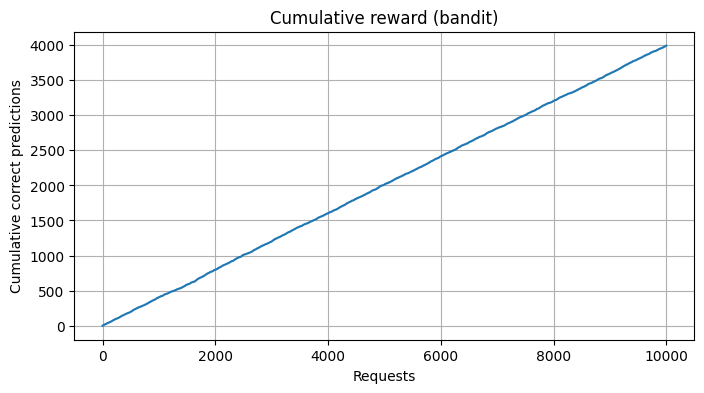

Per-class accuracy (stateless): {0: np.float64(0.625), 1: np.float64(0.503), 2: np.float64(0.036), 3: np.float64(0.124), 4: np.float64(0.272), 5: np.float64(0.552), 6: np.float64(0.602), 7: np.float64(0.545), 8: np.float64(0.356), 9: np.float64(0.398)}
Per-class accuracy (stateful): {0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.0), 3: np.float64(0.0), 4: np.float64(0.0), 5: np.float64(0.719), 6: np.float64(0.647), 7: np.float64(0.63), 8: np.float64(0.81), 9: np.float64(0.643)}


NameError: name 'acc_stat_A' is not defined

In [17]:
# Epsilon-greedy bandit for model selection
# Arms: 0 = stateless model, 1 = stateful model
# Reward: 1 if prediction correct, 0 otherwise.

def bandit_epsilon_greedy(models, dataset, epsilon=0.1):
    n_arms = len(models)
    counts = [0]*n_arms
    values = [0.0]*n_arms
    rewards_history = []
    chosen_history = []

    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    for i, (xb, yb) in enumerate(loader):
        xb, yb = xb.to(device), yb.to(device)
        # choose arm
        if random.random() < epsilon:
            arm = random.randrange(n_arms)
        else:
            arm = int(np.argmax(values))
        model = models[arm]
        model.eval()
        with torch.no_grad():
            out = model(xb)
            pred = out.argmax(dim=1)
            reward = 1 if int(pred.item()) == int(yb.item()) else 0
        # update counts and estimated values (incremental mean)
        counts[arm] += 1
        values[arm] += (reward - values[arm]) / counts[arm]
        rewards_history.append(reward)
        chosen_history.append(arm)
    return counts, values, rewards_history, chosen_history

models_for_bandit = [model_stateless, stateful_model]
counts, values, rewards_history, chosen_history = bandit_epsilon_greedy(models_for_bandit, test_dataset, epsilon=0.1)
print('Bandit counts:', counts)
print('Bandit estimated values (mean reward):', values)
print('Overall bandit average reward:', np.mean(rewards_history))

# Plot cumulative reward over time
cum_rewards = np.cumsum(rewards_history)
plt.figure(figsize=(8,4))
plt.plot(cum_rewards)
plt.title('Cumulative reward (bandit)')
plt.xlabel('Requests')
plt.ylabel('Cumulative correct predictions')
plt.grid(True)
plt.show()

# Reporting helpers: confusion matrices, per-class accuracy
from sklearn.metrics import confusion_matrix

# Evaluate a model on the entire test set and compute per-class accuracy
def per_class_accuracy(model, dataset, num_classes=10):
    loader = DataLoader(dataset, batch_size=128, shuffle=False)
    correct = np.zeros(num_classes, dtype=int)
    total = np.zeros(num_classes, dtype=int)
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1)
            for p, t in zip(preds.cpu().numpy(), yb.cpu().numpy()):
                total[t] += 1
                if p == t:
                    correct[t] += 1
    acc_per = {i: (correct[i]/total[i] if total[i]>0 else 0.0) for i in range(num_classes)}
    return acc_per

acc_per_stateless = per_class_accuracy(model_stateless, test_dataset, num_classes=10)
acc_per_stateful = per_class_accuracy(stateful_model, test_dataset, num_classes=10)
print('Per-class accuracy (stateless):', acc_per_stateless)
print('Per-class accuracy (stateful):', acc_per_stateful)

# Save models and results (to /mnt/data for download)
os.makedirs('/mnt/data/outputs', exist_ok=True)
torch.save(model_init.state_dict(), '/mnt/data/outputs/model_initial.pth')
torch.save(model_stateless.state_dict(), '/mnt/data/outputs/model_stateless.pth')
torch.save(stateful_model.state_dict(), '/mnt/data/outputs/model_stateful.pth')

import json
summary = {
    'initial_valA_acc': accA,
    'initial_on_B_mapped_acc': acc_on_B,
    'stateless_valA': acc_stat_A,
    'stateless_valB': acc_stat_B,
    'stateful_valA': acc_state_A,
    'stateful_valB': acc_state_B,
    'ab_groupA_test_acc': acc_groupA,
    'ab_groupB_test_acc': acc_groupB,
    'bandit_counts': counts,
    'bandit_values': values,
}
with open('/mnt/data/outputs/summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('Saved models and summary to /mnt/data/outputs')
